In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


plt.style.use("seaborn-v0_8")

class IterativeBase():
    def __init__(self,symbol,start,end,amount,use_spread = True, tc = 0.00075):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.use_spread = use_spread
        self.tc = tc
        self.get_data()

    def get_data(self):
        raw = pd.read_csv("detailed.csv",parse_dates = ["time"],index_col = "time").dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw["price"]/raw["price"].shift(1))
        self.data = raw

    def plot_data(self,cols=None):
        if cols is None:
            cols = "price"
        self.data[cols].plot(figsize = (12,8),title = self.symbol)

    def show_data(self):
        return self.data
        

    def get_values(self,bar):
        date = str(self.data.index[bar].date())
        price = round(self.data.price.iloc[bar],5)
        spread = round(self.data.spread.iloc[bar],5)
        return date,price,spread

    def print_current_balance(self,bar):
        date,price,spread = self.get_values(bar)
        print(f"{date} | Current Balance : {round(self.current_balance,2)}")

    def buy_instrument(self,bar,units=None,amount=None):
        date,price,spread = self.get_values(bar)
        if self.use_spread is True:
            price += spread/2
        if amount is not None:
            units = int(amount/price)
        self.current_balance -= units*price
        self.units += units
        self.trades += 1
        print(f"{date} | Buying {units} at {price}")

    def sell_instrument(self,bar,units=None,amount=None):
        date,price,spread = self.get_values(bar)
        if self.use_spread is True:
            price -= spread/2
        if amount is not None:
            units = int(amount/price)
        self.current_balance += units*price
        self.units -= units
        self.trades += 1
        print(f"{date} | Selling {units} at {price}")

    def print_current_position_value(self,bar):
        date,price,spread = self.get_values(bar)
        cpv = self.units*price
        print(f"{date} | Current Position Value : {round(cpv,2)}")
            
    def print_current_nav(self,bar):
        date,price,spread = self.get_values(bar)
        nav = self.units*price + self.current_balance
        print(f"{date} | Net Asset Value : {round(nav,2)}")

    def close_position(self,bar):
        date,price,spread = self.get_values(bar)
        self.current_balance += self.units*price
        self.current_balance -= (abs(self.units)*(spread/2)*self.use_spread)
        print(75*"-")
        print(f"{date} | +++ Closing Final Position +++")
        print(f"{date} | Closing position for {self.units} at {price}")
        self.units = 0
        self.trades += 1
        perf = ((self.current_balance-self.initial_balance)/self.initial_balance) * 100
        self.print_current_balance(bar)
        print(f"{date} | Net Performance = {round(perf,2)}%")
        print(f"{date} | Number of trades executed = {self.trades}")        
        print(75*"-")
        

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

plt.style.use("seaborn-v0_8")

class ML_Backtester():

    def __init__(self,symbol,start,end,amount,use_spread = True, tc = 0.00075):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_balance = amount
        self.current_balance = amount
        self.units = 0
        self.trades = 0
        self.position = 0
        self.use_spread = use_spread
        self.tc = tc
        self.get_data()

    def get_data(self):
        raw = yf.download(self.symbol,self.start,self.end)
        raw["returns"] = np.log(raw["price"]/raw["price"].shift(1))
        self.data = raw

    # repr
    def __repr__(self):
        return f"Iterative ML Backtester (symbol= {self.symbol} , start= {self.start} , end= {self.end})"

    # start of helper methods
    def go_long(self, bar, units = None, amount = None):
        if self.position == -1:
            self.buy_instrument(bar, units = -self.units)
        if units:
            self.buy_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.buy_instrument(bar, amount = amount)

    def go_short(self,bar,units = None, amount = None):
        if self.position == 1:
            self.sell_instrument(bar, units = self.units)
        if units:
            self.sell_instrument(bar, units = units)
        elif amount:
            if amount == "all":
                amount = self.current_balance
            self.sell_instrument(bar, amount = amount)

    def split_data(self, start, end):
        data = self.data.loc[start:end].copy()
        return data

    def prepare_features(self,start,end):
        self.data_subset = self.split_data(start,end)
        self.feature_columns = []
        for lag in range(1,self.lags+1):
            col = f"lag{lag}"
            self.data_subset[col] = self.data_subset["returns"].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def scale_features(self,recalc=True):
        if recalc == True:
            self.means = self.data_subset[self.feature_columns].mean()
            self.stand_devs = self.data_subset[self.feature_columns].std()

        self.data_subset[self.feature_columns] = (self.data_subset[self.feature_columns]-self.means)/self.stand_devs
        
    def fit_model(self,start,end):
        self.prepare_features(start,end)
        self.scale_features(recalc = True)
        self.model.fit(self.data_subset[self.feature_columns],np.sign(self.data_subset["returns"]))

    

    # end of helper methods

    def show_data(self):
        return self.data

    

    def test_ml_strategy(self,train_ratio = 0.7,lags = 5):
        
        # reset
        self.position = 0
        self.trades = 0
        self.current_balance = self.initial_balance
        self.n = 0
        self.results = None

        # assign variables
        self.lags = lags
        self.train_ratio = train_ratio

        # initialisation print out
        print(75*"-")
        print(f"Testing ML strategy | {self.symbol} | lags = {self.lags}")
        print(75*"-")

        # prepare model
        self.model = OneVsRestClassifier(LogisticRegression(C = 1e6, max_iter = 100000))

        # determine datetime for start, end and split (training and testing)
        full_data = self.data.copy()
        split_index = int(len(full_data)*self.train_ratio)
        split_date = full_data.index[split_index-1]
        train_start_date = full_data.index[0]
        test_end_date = full_data.index[-1]

        # fit model (training)
        self.fit_model(train_start_date,split_date)

        # prepare test set
        self.prepare_features(split_date,test_end_date)
        self.scale_features(recalc = False)

        # make predictions (testing)
        predict = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset["prediction"] = predict

        # calculate returns
        self.data_subset["strategy_returns"] = self.data_subset["prediction"]*self.data_subset["returns"]

        # calculate number of trades in each bar
        self.data_subset["trades"] = self.data_subset["prediction"].diff().fillna(0).abs()

        # subtract transaction/trading costs from returns
        self.data_subset["strategy_returns"] = self.data_subset["strategy_returns"] - self.data_subset["trades"]*self.tc

        # calculate cumulative returns for strategy
        self.data_subset["creturns"] = self.data_subset["returns"].cumsum().apply(np.exp)
        self.data_subset["cstrategy"] = self.data_subset["strategy_returns"].cumsum().apply(np.exp)
        self.results = self.data_subset

        # calculate performamce
        perf = self.results["cstrategy"].iloc[-1]
        outperf = perf - self.results["creturns"].iloc[-1]

        print(75*" ")
        print(75*"-")
        print(f"Finished testing ML strategy | {self.symbol} | lags = {self.lags}")
        print(f"Performance of Strategy = {round(perf,6)}, Outperformance = {round(outperf,6)}")
        print(75*"-")

        return round(perf,6), round(outperf,6)
    
    def show_results(self):
        return self.results


    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = f"Logistic Regression: {self.symbol} | TC = {self.tc}"
            self.results[["creturns","cstrategy"]].plot(title=title,figsize = (12,8))

        



In [27]:
ml = ML_Backtester(symbol="EURUSD",start="2006-12-31",end="2020-06-30",amount=10000,use_spread = True,tc=0)

In [28]:
print(ml)

Iterative ML Backtester (symbol= EURUSD , start= 2006-12-31 , end= 2020-06-30)


In [29]:
ml.show_data()

,price,spread,returns
time,,,
2006-12-31 22:00:00+00:00,1.31985,0.00100,NaN
2007-01-01 22:00:00+00:00,1.32734,0.00015,0.005659
2007-01-02 22:00:00+00:00,1.31688,0.00015,-0.007912
2007-01-03 22:00:00+00:00,1.30845,0.00015,-0.006422
2007-01-04 22:00:00+00:00,1.30025,0.00100,-0.006287
...,...,...,...
2020-06-23 21:00:00+00:00,1.12507,0.00030,-0.005151
2020-06-24 21:00:00+00:00,1.12180,0.00023,-0.002911
2020-06-25 21:00:00+00:00,1.12184,0.00041,0.000036


In [30]:
ml.test_ml_strategy(train_ratio=0.8,lags = 5)

---------------------------------------------------------------------------
Testing ML strategy | EURUSD | lags = 5
---------------------------------------------------------------------------
                                                                           
---------------------------------------------------------------------------
Finished testing ML strategy | EURUSD | lags = 5
Performance of Strategy = 1.269857, Outperformance = 0.27175
---------------------------------------------------------------------------


(1.269857, 0.27175)

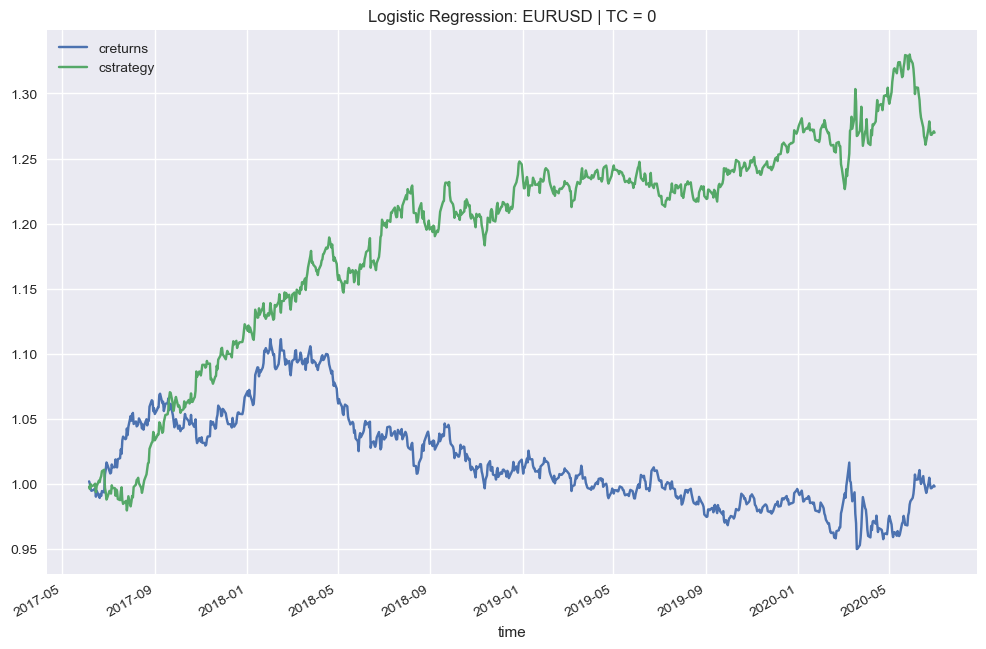

In [31]:
ml.plot_results()

In [32]:
ml.show_results()

,price,spread,returns,lag1,lag2,lag3,lag4,lag5,prediction,strategy_returns,trades,creturns,cstrategy
time,,,,,,,,,,,,,
2017-06-05 21:00:00+00:00,1.12772,0.00021,0.002024,-0.417770,1.072721,-0.461303,0.884178,0.357095,-1.0,-0.002024,0.0,1.002026,0.997978
2017-06-06 21:00:00+00:00,1.12566,0.00038,-0.001828,0.353811,-0.417452,1.072758,-0.460791,0.883961,1.0,-0.001828,2.0,1.000195,0.996155
2017-06-07 21:00:00+00:00,1.12142,0.00049,-0.003774,-0.304134,0.354001,-0.417183,1.072841,-0.460874,-1.0,0.003774,2.0,0.996428,0.999922
2017-06-08 21:00:00+00:00,1.11959,0.00052,-0.001633,-0.636408,-0.303835,0.354150,-0.416684,1.072606,1.0,-0.001633,2.0,0.994802,0.998290
2017-06-11 21:00:00+00:00,1.12036,0.00023,0.000688,-0.270799,-0.636054,-0.303584,0.354434,-0.416772,1.0,0.000688,0.0,0.995486,0.998976
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23 21:00:00+00:00,1.12507,0.00030,-0.005151,0.722504,1.286932,-0.407915,-0.579562,-0.288423,1.0,-0.005151,0.0,0.999671,1.271937
2020-06-24 21:00:00+00:00,1.12180,0.00023,-0.002911,-0.871604,0.722632,1.286936,-0.407418,-0.579634,1.0,-0.002911,0.0,0.996766,1.268240
2020-06-25 21:00:00+00:00,1.12184,0.00041,0.000036,-0.488997,-0.871211,0.722724,1.286959,-0.407507,-1.0,-0.000036,2.0,0.996801,1.268195
